The updated models are in the folder `lstm_model_fix` and the models before update are in the folder `lstm_model`. When running the code, please modify the datapath first.

# Import Packages and Load Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, GRU
import json
from keras.models import model_from_json
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import f1_score
import tensorflow as tf
import os
import random
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datapath = '/content/drive/My Drive/BT4222 Project/'

In [ ]:
df = pd.read_csv(datapath + 'data/final_data.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df['text'] = df['text'].astype('str')
df.head()

,keyword,location,text,target
0,no_keyword,no_location,Our Deeds are the Reason of this earthquake Ma...,1
1,no_keyword,no_location,Forest fire near La Ronge Sask Canada,1
2,no_keyword,no_location,All residents asked to shelter in place are be...,1
3,no_keyword,no_location,people receive wildfires evacuation orders in ...,1
4,no_keyword,no_location,Just got sent this photo from Ruby Alaska as s...,1


# Prepare Features

In [ ]:
#set seed 
seed_value = 4222
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.get_session(sess)

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# Embedding dimension
EMBEDDING_DIM = 100

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Number of unique tokens: %s unique tokens.' % len(word_index))

Number of unique tokens: 42177 unique tokens.


In [ ]:
# Truncate and pad the input sequences so that they are all in the same length for modeling.
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of text:', X.shape)

Shape of text: (22624, 250)


In [ ]:
y = df['target'].values
print('Shape of target: ', y.shape)

Shape of target:  (22624,)


In [ ]:
# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)
print('Shape of full training set: ', X_train.shape, y_train.shape)
print('Shape of training set: ', X_train_train.shape, y_train_train.shape)
print('Shape of validation set: ', X_val.shape, y_val.shape)
print('Shape of test set: ', X_test.shape, y_test.shape)

Shape of full training set:  (18099, 250) (18099,)
Shape of training set:  (13574, 250) (13574,)
Shape of validation set:  (4525, 250) (4525,)
Shape of test set:  (4525, 250) (4525,)


# LSTM

## MSE + Sigmoid

### Train Model

In [ ]:
model = Sequential()
# Add embedded layer that uses 100 length vectors to represent each word
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# Add layer for variational dropout
model.add(SpatialDropout1D(0.2))
# Add LSTM layer with 100 memory units
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# Add output layer which creates 2 output values, one for the class "disaster tweet" and one for the other class "non-disaster tweet"
model.add(Dense(2, activation='sigmoid'))

In [ ]:
# Compile the model with "mean_squared_error" as the loss function and "adam" as the optimiser
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

epochs = 20
batch_size = 640
# Fit the model and stop training once the loss is no longer decreasing
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001)])

Epoch 1/20
23/23 [==============================] - 87s 4s/step - loss: 0.0628 - accuracy: 0.6434 - val_loss: 0.1233 - val_accuracy: 0.4859
Epoch 2/20
23/23 [==============================] - 84s 4s/step - loss: 0.0470 - accuracy: 0.5526 - val_loss: 0.1250 - val_accuracy: 0.5017
Epoch 3/20
23/23 [==============================] - 84s 4s/step - loss: 0.0346 - accuracy: 0.5894 - val_loss: 0.1298 - val_accuracy: 0.5343
Epoch 4/20
23/23 [==============================] - 84s 4s/step - loss: 0.0257 - accuracy: 0.6350 - val_loss: 0.1355 - val_accuracy: 0.6528
Epoch 5/20
23/23 [==============================] - 84s 4s/step - loss: 0.0187 - accuracy: 0.7762 - val_loss: 0.1377 - val_accuracy: 0.6845
Epoch 6/20
23/23 [==============================] - 84s 4s/step - loss: 0.0171 - accuracy: 0.8022 - val_loss: 0.1434 - val_accuracy: 0.7340
Epoch 7/20
23/23 [==============================] - 84s 4s/step - loss: 0.0149 - accuracy: 0.8221 - val_loss: 0.1431 - val_accuracy: 0.6166
Epoch 8/20
23/23 [==

In [ ]:
# Save the model
model_json = model.to_json()
with open(datapath + 'code/lstm_model_fix/lstm_model_mse_sigmoid.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(datapath + 'code/lstm_model_fix/lstm_model_mse_sigmoid.h5')

In [ ]:
# Save the history of the model
history_dict = history.history
json.dump(history_dict, open(datapath + 'code/lstm_model_fix/lstm_history_mse_sigmoid.json', 'w'))

### Test Model

In [ ]:
# Load model
json_file = open(datapath + 'code/lstm_model_fix/lstm_model_mse_sigmoid.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(datapath + 'code/lstm_model_fix/lstm_model_mse_sigmoid.h5')
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Load history of the model
history_dict = json.load(open(datapath + 'code/lstm_model_fix/lstm_history_mse_sigmoid.json', 'r'))

In [ ]:
accuracy = model.evaluate(X_val, y_val)
y_pred_class = model.predict_classes(X_val)
f1 = f1_score(y_val, y_pred_class)
print('Validation set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.3f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_val, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 9s 60ms/step - loss: 0.0369 - accuracy: 0.6985


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Validation set
Loss: 0.039
Accuracy: 0.691
AUC score: 0.750
F1 score: 0.599


In [ ]:
accuracy = model.evaluate(X_test, y_test)
y_pred_class = model.predict_classes(X_test)
f1 = f1_score(y_test, y_pred_class)
print('Test set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.3f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_test, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 8s 59ms/step - loss: 0.1533 - accuracy: 0.6168


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test set
Loss: 0.153
Accuracy: 0.617
AUC score: 0.631
F1 score: 0.474


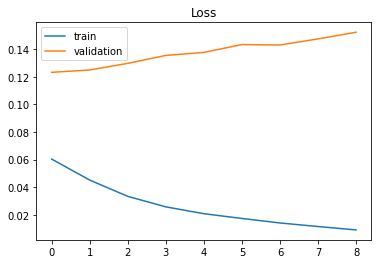

In [ ]:
# Plot the loss for each epoch
plt.plot(history_dict['loss'], label = 'train')
plt.plot(history_dict['val_loss'], label = 'validation')
plt.legend()
plt.title('Loss')
plt.savefig(datapath + 'code/lstm_model_fix/loss_plot_mse_sigmoid.png')

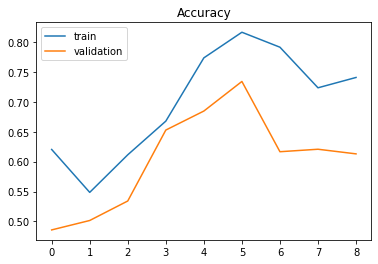

In [ ]:
# Plot the accuracy for each epoch
plt.plot(history_dict['accuracy'], label = 'train')
plt.plot(history_dict['val_accuracy'], label = 'validation')
plt.legend()
plt.title('Accuracy')
plt.savefig(datapath + 'code/lstm_model_fix/accuracy_plot_mse_sigmoid.png')

## Binary_crossentopy + Sigmoid

### Train Model

In [ ]:
model = Sequential()
# Add embedded layer that uses 100 length vectors to represent each word
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# Add layer for variational dropout
model.add(SpatialDropout1D(0.2))
# Add LSTM layer with 100 memory units
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# Add output layer
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

epochs = 20
batch_size = 64
# Fit the model and stop training once the loss is no longer decreasing
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001)])

Epoch 1/20
227/227 [==============================] - 171s 740ms/step - loss: 0.5276 - accuracy: 0.7693 - val_loss: 0.3872 - val_accuracy: 0.8464
Epoch 2/20
227/227 [==============================] - 167s 736ms/step - loss: 0.2733 - accuracy: 0.8945 - val_loss: 0.4116 - val_accuracy: 0.8307
Epoch 3/20
227/227 [==============================] - 166s 732ms/step - loss: 0.1643 - accuracy: 0.9435 - val_loss: 0.4638 - val_accuracy: 0.8381
Epoch 4/20
227/227 [==============================] - 167s 734ms/step - loss: 0.0893 - accuracy: 0.9691 - val_loss: 0.5747 - val_accuracy: 0.8331


In [ ]:
# Save the model
model_json = model.to_json()
with open(datapath + 'code/lstm_model_fix/lstm_model_binary_crossentropy_sigmoid.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(datapath + 'code/lstm_model_fix/lstm_model_binary_crossentropy_sigmoid.h5')

In [ ]:
# Save the history of the model
history_dict = history.history
json.dump(history_dict, open(datapath + 'code/lstm_model_fix/lstm_history_binary_crossentropy_sigmoid.json', 'w'))

### Test Model

In [ ]:
# Load model
json_file = open(datapath + 'code/lstm_model_fix/lstm_model_binary_crossentropy_sigmoid.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(datapath + 'code/lstm_model_fix/lstm_model_binary_crossentropy_sigmoid.h5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Load history of the model
history_dict = json.load(open(datapath + 'code/lstm_model_fix/lstm_history_binary_crossentropy_sigmoid.json', 'r'))

In [ ]:
accuracy = model.evaluate(X_val, y_val)
y_pred_class = model.predict_classes(X_val)
f1 = f1_score(y_val, y_pred_class)
print('Validation set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.3f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_val, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 10s 66ms/step - loss: 0.1478 - accuracy: 0.9566


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Validation set
Loss: 0.164
Accuracy: 0.951
AUC score: 0.922
F1 score: 0.903


In [ ]:
accuracy = model.evaluate(X_test, y_test)
y_pred_class = model.predict_classes(X_test)
f1 = f1_score(y_test, y_pred_class)
print('Test set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.3f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_test, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 9s 64ms/step - loss: 0.5833 - accuracy: 0.8294


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test set
Loss: 0.583
Accuracy: 0.829
AUC score: 0.745
F1 score: 0.636


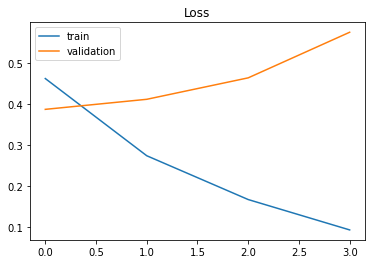

In [ ]:
# Plot the loss for each epoch
plt.plot(history_dict['loss'], label = 'train')
plt.plot(history_dict['val_loss'], label = 'validation')
plt.legend()
plt.title('Loss')
plt.savefig(datapath + 'code/lstm_model_fix/loss_plot_binary_crossentropy_sigmoid.png')

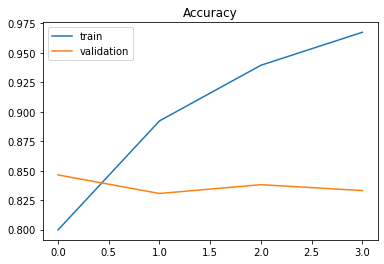

In [ ]:
# Plot the accuracy for each epoch
plt.plot(history_dict['accuracy'], label = 'train')
plt.plot(history_dict['val_accuracy'], label = 'validation')
plt.legend()
plt.title('Accuracy')
plt.savefig(datapath + 'code/lstm_model_fix/accuracy_plot_binary_crossentropy_sigmoid.png')

## MSE + ReLU

### Train Model

In [ ]:
model = Sequential()
# Add embedded layer that uses 100 length vectors to represent each word
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# Add layer for variational dropout
model.add(SpatialDropout1D(0.2))
# Add LSTM layer with 100 memory units
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# Add output layer
model.add(Dense(1, activation='relu'))
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

epochs = 20
batch_size = 64
# Fit the model and stop training once the loss is no longer decreasing
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001)])

Epoch 1/20
227/227 [==============================] - 172s 745ms/step - loss: 0.1688 - accuracy: 0.7736 - val_loss: 0.1217 - val_accuracy: 0.8414
Epoch 2/20
227/227 [==============================] - 169s 744ms/step - loss: 0.0775 - accuracy: 0.9038 - val_loss: 0.1277 - val_accuracy: 0.8340
Epoch 3/20
227/227 [==============================] - 167s 735ms/step - loss: 0.0424 - accuracy: 0.9534 - val_loss: 0.1305 - val_accuracy: 0.8359
Epoch 4/20
227/227 [==============================] - 168s 741ms/step - loss: 0.0296 - accuracy: 0.9698 - val_loss: 0.1414 - val_accuracy: 0.8312


In [ ]:
# Save the model
model_json = model.to_json()
with open(datapath + 'code/lstm_model_fix/lstm_model_mse_relu.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(datapath + 'code/lstm_model_fix/lstm_model_mse_relu.h5')

In [ ]:
# Save the history of the model
history_dict = history.history
json.dump(history_dict, open(datapath + 'code/lstm_model_fix/lstm_history_mse_relu.json', 'w'))

### Test Model

In [ ]:
# Load model
json_file = open(datapath + 'code/lstm_model_fix/lstm_model_mse_relu.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(datapath + 'code/lstm_model_fix/lstm_model_mse_relu.h5')
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Load history of the model
history_dict = json.load(open(datapath + 'code/lstm_model_fix/lstm_history_mse_relu.json', 'r'))

In [ ]:
accuracy = model.evaluate(X_val, y_val)
y_pred_class = model.predict_classes(X_val)
f1 = f1_score(y_val, y_pred_class)
print('Validation set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.3f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_val, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 11s 74ms/step - loss: 0.0440 - accuracy: 0.9515


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Validation set
Loss: 0.049
Accuracy: 0.946
AUC score: 0.911
F1 score: 0.891


In [ ]:
accuracy = model.evaluate(X_test, y_test)
y_pred_class = model.predict_classes(X_test)
f1 = f1_score(y_test, y_pred_class)
print('Test set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.3f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_test, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 11s 77ms/step - loss: 0.1390 - accuracy: 0.8351


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test set
Loss: 0.139
Accuracy: 0.835
AUC score: 0.751
F1 score: 0.646


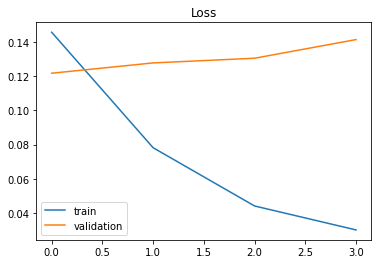

In [ ]:
# Plot the loss for each epoch
plt.plot(history_dict['loss'], label = 'train')
plt.plot(history_dict['val_loss'], label = 'validation')
plt.legend()
plt.title('Loss')
plt.savefig(datapath + 'code/lstm_model_fix/loss_plot_mse_relu.png')

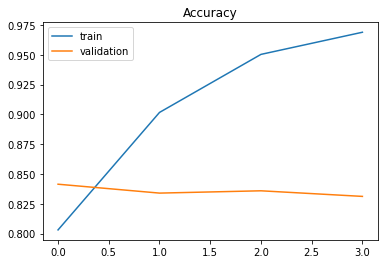

In [ ]:
# Plot the accuracy for each epoch
plt.plot(history_dict['accuracy'], label = 'train')
plt.plot(history_dict['val_accuracy'], label = 'validation')
plt.legend()
plt.title('Accuracy')
plt.savefig(datapath + 'code/lstm_model_fix/accuracy_plot_mse_relu.png')

## Binary_crossentropy + relu

### Train Model

In [ ]:
model = Sequential()
# Add embedded layer that uses 100 length vectors to represent each word
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# Add layer for variational dropout
model.add(SpatialDropout1D(0.2))
# Add LSTM layer with 100 memory units
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# Add output layer
model.add(Dense(1, activation='relu'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

epochs = 20
batch_size = 64
# Fit the model and stop training once the loss is no longer decreasing
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001)])

Epoch 1/20
227/227 [==============================] - 175s 756ms/step - loss: 0.6267 - accuracy: 0.7642 - val_loss: 0.4735 - val_accuracy: 0.7762
Epoch 2/20
227/227 [==============================] - 169s 745ms/step - loss: 0.3713 - accuracy: 0.8589 - val_loss: 0.7192 - val_accuracy: 0.7953
Epoch 3/20
227/227 [==============================] - 168s 742ms/step - loss: 0.2736 - accuracy: 0.9047 - val_loss: 0.7487 - val_accuracy: 0.8406
Epoch 4/20
227/227 [==============================] - 167s 736ms/step - loss: 0.1847 - accuracy: 0.9605 - val_loss: 0.8827 - val_accuracy: 0.8398
Epoch 5/20
227/227 [==============================] - 167s 734ms/step - loss: 0.1312 - accuracy: 0.9786 - val_loss: 1.1280 - val_accuracy: 0.8296
Epoch 6/20
227/227 [==============================] - 167s 734ms/step - loss: 0.1236 - accuracy: 0.9840 - val_loss: 1.2539 - val_accuracy: 0.8218


In [ ]:
# Save the model
model_json = model.to_json()
with open(datapath + 'code/lstm_model_fix/lstm_model_binary_crossentropy_relu.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(datapath + 'code/lstm_model_fix/lstm_model_binary_crossentropy_relu.h5')

In [ ]:
# Save the history of the model
history_dict = history.history
json.dump(history_dict, open(datapath + 'code/lstm_model_fix/lstm_history_binary_crossentropy_relu.json', 'w'))

### Test Model

In [ ]:
# Load model
json_file = open(datapath + 'code/lstm_model_fix/lstm_model_binary_crossentropy_relu.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(datapath + 'code/lstm_model_fix/lstm_model_binary_crossentropy_relu.h5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Load history of the model
history_dict = json.load(open(datapath + 'code/lstm_model_fix/lstm_history_binary_crossentropy_relu.json', 'r'))

In [ ]:
accuracy = model.evaluate(X_val, y_val)
y_pred_class = model.predict_classes(X_val)
f1 = f1_score(y_val, y_pred_class)
print('Validation set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.4f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_val, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 9s 61ms/step - loss: 0.3009 - accuracy: 0.9572


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Validation set
Loss: 0.356
Accuracy: 0.9527
AUC score: 0.937
F1 score: 0.910


In [ ]:
accuracy = model.evaluate(X_test, y_test)
y_pred_class = model.predict_classes(X_test)
f1 = f1_score(y_test, y_pred_class)
print('Test set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.4f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_test, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 9s 60ms/step - loss: 1.3163 - accuracy: 0.8199


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test set
Loss: 1.316
Accuracy: 0.8199
AUC score: 0.759
F1 score: 0.647


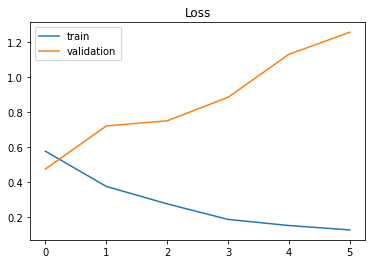

In [ ]:
# Plot the loss for each epoch
plt.plot(history_dict['loss'], label = 'train')
plt.plot(history_dict['val_loss'], label = 'validation')
plt.legend()
plt.title('Loss')
plt.savefig(datapath + 'code/lstm_model_fix/loss_plot_binary_crossentropy_relu.png')

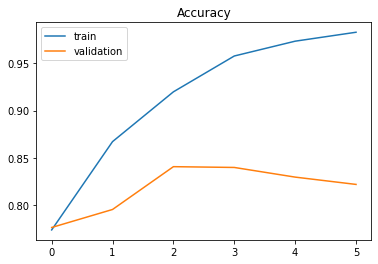

In [ ]:
# Plot the accuracy for each epoch
plt.plot(history_dict['accuracy'], label = 'train')
plt.plot(history_dict['val_accuracy'], label = 'validation')
plt.legend()
plt.title('Accuracy')
plt.savefig(datapath + 'code/lstm_model_fix/accuracy_plot_binary_crossentropy_relu.png')

# Bidirectional LSTM

## Train Model

In [ ]:
model = Sequential()
# Add embedded layer that uses 100 length vectors to represent each word
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# Add layer for variational dropout
model.add(SpatialDropout1D(0.2))
# Add LSTM layer with 100 memory units
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(BatchNormalization())
# Add output layer
model.add(Dense(1, activation='relu'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

epochs = 11
batch_size = 64
# Fit the model and stop training once the loss is no longer decreasing
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001)])

Epoch 1/11
227/227 [==============================] - 342s 1s/step - loss: 2.2260 - accuracy: 0.6771 - val_loss: 4.0139 - val_accuracy: 0.7398
Epoch 2/11
227/227 [==============================] - 332s 1s/step - loss: 2.1927 - accuracy: 0.7554 - val_loss: 3.6071 - val_accuracy: 0.7417
Epoch 3/11
227/227 [==============================] - 328s 1s/step - loss: 1.9062 - accuracy: 0.7990 - val_loss: 2.1241 - val_accuracy: 0.8113
Epoch 4/11
227/227 [==============================] - 329s 1s/step - loss: 1.4096 - accuracy: 0.8474 - val_loss: 1.9577 - val_accuracy: 0.8193
Epoch 5/11
227/227 [==============================] - 332s 1s/step - loss: 1.0316 - accuracy: 0.8814 - val_loss: 1.7372 - val_accuracy: 0.8022
Epoch 6/11
227/227 [==============================] - 333s 1s/step - loss: 0.9021 - accuracy: 0.9046 - val_loss: 1.8678 - val_accuracy: 0.7890
Epoch 7/11
227/227 [==============================] - 332s 1s/step - loss: 0.8817 - accuracy: 0.8906 - val_loss: 1.7336 - val_accuracy: 0.8169

In [ ]:
# Save the model
model_json = model.to_json()
with open(datapath + 'code/lstm_model_fix/lstm_model_bidirectional.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(datapath + 'code/lstm_model_fix/lstm_model_bidirectional.h5')

In [ ]:
# Save the history of the model
history_dict = history.history
json.dump(history_dict, open(datapath + 'code/lstm_model_fix/lstm_history_bidirectional.json', 'w'))

## Test Model

In [ ]:
# Load model
json_file = open(datapath + 'code/lstm_model_fix/lstm_model_bidirectional.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(datapath + 'code/lstm_model_fix/lstm_model_bidirectional.h5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Load history of the model
history_dict = json.load(open(datapath + 'code/lstm_model_fix/lstm_history_bidirectional.json', 'r'))

In [ ]:
accuracy = model.evaluate(X_val, y_val)
y_pred_class = model.predict_classes(X_val)
f1 = f1_score(y_val, y_pred_class)
print('Validation set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.4f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_val, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 17s 111ms/step - loss: 0.9296 - accuracy: 0.9089


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Validation set
Loss: 0.943
Accuracy: 0.9090
AUC score: 0.864
F1 score: 0.817


In [ ]:
accuracy = model.evaluate(X_test, y_test)
y_pred_class = model.predict_classes(X_test)
f1 = f1_score(y_test, y_pred_class)
print('Test set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.4f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_test, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 16s 111ms/step - loss: 1.6721 - accuracy: 0.8241


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test set
Loss: 1.672
Accuracy: 0.8241
AUC score: 0.735
F1 score: 0.620


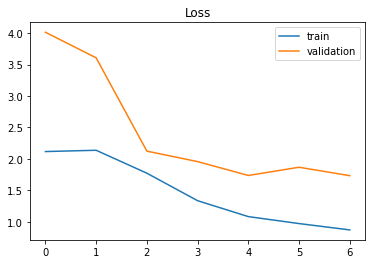

In [ ]:
# Plot the loss for each epoch
plt.plot(history_dict['loss'], label = 'train')
plt.plot(history_dict['val_loss'], label = 'validation')
plt.legend()
plt.title('Loss')
plt.savefig(datapath + 'code/lstm_model_fix/loss_plot_bidirectional.png')

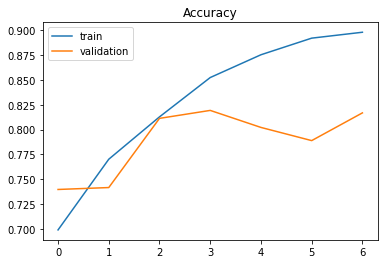

In [ ]:
# Plot the accuracy for each epoch
plt.plot(history_dict['accuracy'], label = 'train')
plt.plot(history_dict['val_accuracy'], label = 'validation')
plt.legend()
plt.title('Accuracy')
plt.savefig(datapath + 'code/lstm_model_fix/accuracy_plot_bidirectional.png')

# GRU

## Train Model

In [ ]:
model = Sequential()
# Add embedded layer that uses 100 length vectors to represent each word
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# Add layer for variational dropout
model.add(SpatialDropout1D(0.2))
# Add LSTM layer with 100 memory units
model.add(GRU(100))
# Add output layer
model.add(Dense(1, activation='relu'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

epochs = 20
batch_size = 64
# Fit the model and stop training once the loss is no longer decreasing
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001)])

Epoch 1/20
227/227 [==============================] - 72s 310ms/step - loss: 0.6518 - accuracy: 0.7617 - val_loss: 0.5345 - val_accuracy: 0.7489
Epoch 2/20
227/227 [==============================] - 69s 305ms/step - loss: 0.4565 - accuracy: 0.8064 - val_loss: 0.5760 - val_accuracy: 0.7986
Epoch 3/20
227/227 [==============================] - 70s 307ms/step - loss: 0.2905 - accuracy: 0.9077 - val_loss: 0.7629 - val_accuracy: 0.7854
Epoch 4/20
227/227 [==============================] - 70s 306ms/step - loss: 0.3946 - accuracy: 0.8833 - val_loss: 0.9384 - val_accuracy: 0.7903
Epoch 5/20
227/227 [==============================] - 70s 307ms/step - loss: 0.1813 - accuracy: 0.9565 - val_loss: 1.0737 - val_accuracy: 0.7848


In [ ]:
# Save the model
model_json = model.to_json()
with open(datapath + 'code/lstm_model_fix/lstm_model_gru.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(datapath + 'code/lstm_model_fix/lstm_model_gru.h5')

In [ ]:
# Save the history of the model
history_dict = history.history
json.dump(history_dict, open(datapath + 'code/lstm_model_fix/lstm_history_gru.json', 'w'))

## Test Model

In [ ]:
# Load model
json_file = open(datapath + 'code/lstm_model_fix/lstm_model_gru.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(datapath + 'code/lstm_model_fix/lstm_model_gru.h5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Load history of the model
history_dict = json.load(open(datapath + 'code/lstm_model_fix/lstm_history_gru.json', 'r'))

In [ ]:
accuracy = model.evaluate(X_val, y_val)
y_pred_class = model.predict_classes(X_val)
f1 = f1_score(y_val, y_pred_class)
print('Validation set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.4f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_val, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 6s 40ms/step - loss: 0.2859 - accuracy: 0.9394


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Validation set
Loss: 0.330
Accuracy: 0.9333
AUC score: 0.909
F1 score: 0.872


In [ ]:
accuracy = model.evaluate(X_test, y_test)
y_pred_class = model.predict_classes(X_test)
f1 = f1_score(y_test, y_pred_class)
print('Test set')
print('Loss: {:0.3f}'.format(accuracy[0]))
print('Accuracy: {:0.4f}'.format(accuracy[1]))
print('AUC score: {:0.3f}'.format(roc_auc_score(y_test, y_pred_class)))
print('F1 score: {:0.3f}'.format(f1))

142/142 [==============================] - 6s 40ms/step - loss: 1.0216 - accuracy: 0.7881


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test set
Loss: 1.022
Accuracy: 0.7881
AUC score: 0.729
F1 score: 0.599


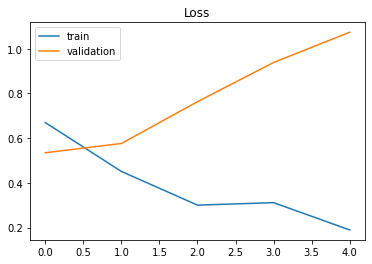

In [ ]:
# Plot the loss for each epoch
plt.plot(history_dict['loss'], label = 'train')
plt.plot(history_dict['val_loss'], label = 'validation')
plt.legend()
plt.title('Loss')
plt.savefig(datapath + 'code/lstm_model_fix/loss_plot_gru.png')

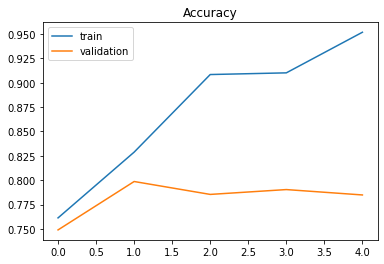

In [ ]:
# Plot the accuracy for each epoch
plt.plot(history_dict['accuracy'], label = 'train')
plt.plot(history_dict['val_accuracy'], label = 'validation')
plt.legend()
plt.title('Accuracy')
plt.savefig(datapath + 'code/lstm_model_fix/accuracy_plot_gru.png')